*Author: Zao Richardson Ansah* <br>
*Project Date: 3/09/2022 - 6/09/2022*

# Project: Appointments "No Show" 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project we will be analyzing the [Appointments No-Show dataset](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv), based on medical appointments in Brazil. In particularly, we will try to investigate if there are any factors that influence the appointment attendance (independent variable).

Here are the research questions that will guide the analysis:

1. Does gender impact the attendance?
2. Is there a specific age group with higher attendance rate?
3. How does the date difference between the scheduled and the appointment day impact the attendance rate? Does same day appointment have a higher attendance rate (which could be viewed as emergency visits)?
4. Are there specific neighborhoods associated with higher No-Show?
0. Does receiving a scholarship (Bolsa Familia) has any impact on the attendance?
5. Does any medical condition impact the attendance rate?
6. Does receiving the SMS reminder has any impact on the attendance?
8. Is it possible to, based on the available features, predict whether a patient will show up to their scheduled appointment?

> **Limitation**: it is important to highlight that, without the proper hypothesis testing techniques, the conclusions based solely on descriptive statistics are merely tentative.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id='wrangling'></a>
## Data Wrangling

In [2]:
df = pd.read_csv("NoShowAppointment.csv")
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


First, let's make sure all column names are lower case and separated by underscore:

In [3]:
df.columns.str.lower()

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no-show'],
      dtype='object')

In [4]:
# Manually editing the col names for readibility and typos
df.columns = ['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighborhood', 'scholarship', 'hypertension',
       'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show']

In [5]:
# Checking shape of dataset : rows vs cols
df.shape

(110527, 14)

This dataset contains 110,527 rows of medical appointment data, with 14 Features.

In [6]:
# Checking missing data and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   patient_id       110527 non-null  float64
 1   appointment_id   110527 non-null  int64  
 2   gender           110527 non-null  object 
 3   scheduled_day    110527 non-null  object 
 4   appointment_day  110527 non-null  object 
 5   age              110527 non-null  int64  
 6   neighborhood     110527 non-null  object 
 7   scholarship      110527 non-null  int64  
 8   hypertension     110527 non-null  int64  
 9   diabetes         110527 non-null  int64  
 10  alcoholism       110527 non-null  int64  
 11  handicap         110527 non-null  int64  
 12  sms_received     110527 non-null  int64  
 13  no_show          110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There is no missing data - which is a good thing!

We need to fix the data type of some columns:

+ **Gender**: String -> Category (M: Male | F: Female)
+ **Scheduled Day** / **Appointment Day**: String -> Date
+ **No-Show**: String -> Integer (1: Yes | 0: No)

In [7]:
# Checking for duplicates
df.duplicated().sum() , df.duplicated('patient_id').sum(), df.duplicated('appointment_id').sum()

(0, 48228, 0)

There are no duplicated rows. Although there are 48,228 patients that scheduled more than one appointment. All Appointment IDs are unique values.

The columns "Patient ID" and "Appointment ID" doesn't seem very promising to our analysis, so we can remove them as well:

In [8]:
df.drop(['patient_id','appointment_id'],axis=1, inplace=True)

In [9]:
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Looking at the overall description of the data, the column Age seems off: the minimum value is -1, which doesn't make sense. In addition, the maximum value is 115, which seems too high. We need to investigate for possible outlier and remove negative values:

In [10]:
df[df.age < 0]

,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


Outlier Threshold: 110


,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
63912,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
97666,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


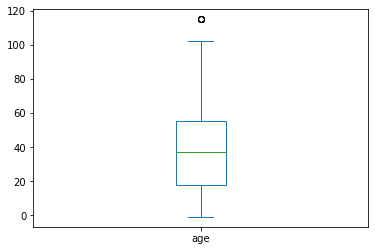

In [11]:
# Box-plot to visualize threshold for possible outliers
df.age.plot(kind='box');
iqr = df.age.quantile(0.75) - df.age.quantile(0.25)
outlier = df.age.quantile(0.75) + 1.5*iqr
print('Outlier Threshold:', int(round(outlier,0)))
df[df.age > 110]

Looks like there is only one negative entry. And five entries with age greater than the ourlier threshold of 110 years.
Let's go ahead and remove them:

In [12]:
df = df[(df.age >=0) & (df.age <=110)]
df.shape

(110521, 12)

Let's tweak this dataset a little more by renaming the column "no_show" as "attended", since it is more natural to think of 'yes' as a positive observation.

We will rename the column and replace the observations No/Yes with 1/0:

> *Obs: since "attended" is going to be our dependent variable, storing it as a binary 1/0 will make the analysis easier, because the mean will automatically represent the proportion.*

In [13]:
df.rename(columns={'no_show': 'attended'}, inplace=True)
df.attended.replace(['No', 'Yes'], [1, 0], inplace=True)
df.head(1)

,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,attended
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,1


Good. Our changes look good so far.

Now, let's fix the data types:

In [14]:
df.gender = df.gender.astype('category')
df.scheduled_day = pd.to_datetime(df.scheduled_day)
df.appointment_day = pd.to_datetime(df.appointment_day)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   gender           110521 non-null  category           
 1   scheduled_day    110521 non-null  datetime64[ns, UTC]
 2   appointment_day  110521 non-null  datetime64[ns, UTC]
 3   age              110521 non-null  int64              
 4   neighborhood     110521 non-null  object             
 5   scholarship      110521 non-null  int64              
 6   hypertension     110521 non-null  int64              
 7   diabetes         110521 non-null  int64              
 8   alcoholism       110521 non-null  int64              
 9   handicap         110521 non-null  int64              
 10  sms_received     110521 non-null  int64              
 11  attended         110521 non-null  int64              
dtypes: category(1), datetime64[ns, UTC](2), int64(8), object(1

There is one last check before moving on to analyze the data: what do the datetime columns look  like?

Let's create a new column calculating the difference between the date of the appointment and when it was scheduled:

In [16]:
df['delta_date'] = df.appointment_day - df.scheduled_day
df.delta_date.describe()

count                        110521
mean      9 days 17:08:35.550203128
std      15 days 05:51:35.542808416
min               -7 days +10:10:40
25%               -1 days +15:41:32
50%                 3 days 11:22:48
75%                14 days 07:41:28
max               178 days 13:19:01
Name: delta_date, dtype: object

Strange... looks like there are some negative values. We need to further investigate this:

In [17]:
# Looking only at negative values
df[df.delta_date < pd.Timedelta(0, 'D')][['scheduled_day','appointment_day', 'delta_date']].head()

,scheduled_day,appointment_day,delta_date
0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,-1 days +05:21:52
1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,-1 days +07:51:33
2,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,-1 days +07:40:56
3,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,-1 days +06:30:29
4,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,-1 days +07:52:37


Ok... the -1 day difference can be explained due to the fact that Appointment Day column does not contain information regarding the time of the appointment.

For this particular case, we can assume the appointment was actually scheduled on the same day. Let's fix the "Delta Date" column to reflect this assumption:

In [18]:
mask = ((df.delta_date <= pd.Timedelta(0, 'D')) & (df.delta_date >= pd.Timedelta(-1, 'D')))
df[mask].delta_date.aggregate([min,max, 'count']) # 38562 occurrences of value: -1 day

min      -1 days +03:15:06
max      -1 days +17:50:24
count                38561
Name: delta_date, dtype: object

In [19]:
# Replacing values based on condition
df.loc[mask, 'delta_date'] = pd.Timedelta(0, 'D')
df[mask].head()

,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,attended,delta_date
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0 days
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0 days
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,1,0 days
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0 days
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0 days


In [20]:
# Checking for correct replacement
df[mask].delta_date.aggregate([min,max, 'count'])

min      0 days 00:00:00
max      0 days 00:00:00
count              38561
Name: delta_date, dtype: object

The alteration on column Delta Date was successful: we substituted 38,562 entries from -1 days to 0 day - representing same day appointment.

But we still need to check the other negative values:

In [21]:
df[df.delta_date < pd.Timedelta(0,'D')]

,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,attended,delta_date
27033,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,0,-2 days +13:08:07
55226,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,-2 days +09:09:19
64175,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,0,-2 days +10:16:02
71533,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,-7 days +10:10:40
72362,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,0,-2 days +17:09:03


There are 4 entries with negative two days and 1 entry with negative seven days. Since we can't come up with a reasonable explanation for these cases, we will remove them from the dataset:

In [22]:
df.shape

(110521, 13)

In [23]:
df = df[df.delta_date >= pd.Timedelta(0,'D')]
df.shape

(110516, 13)

We completed the data cleaning process and transformation, ending up with 110,521 observations and 13 columns.

Now we are finally ready to start investigating and exploring our dataset!

<a id='eda'></a>
## Exploratory Data Analysis

### Dataset Description

In [24]:
# Quickly obtaining proportions for the binary features
ref = ['scholarship', 'hypertension','diabetes', 'alcoholism', 'handicap',
       'sms_received', 'attended']
df[ref].mean().round(2)

scholarship     0.10
hypertension    0.20
diabetes        0.07
alcoholism      0.03
handicap        0.02
sms_received    0.32
attended        0.80
dtype: float64

In [25]:
(df.groupby('gender').size() / df.shape[0]).round(2)

gender
F    0.65
M    0.35
dtype: float64

Looking at the proportion of the binary features we can see that, for this sample:
+ There is almost 2 times more female than male patients;
+ Around 10% of patients receive the Scholarship ('Bolsa Familia');
+ About 20% of patients suffer from hypertension;
+ 7% of patients have diabetes;
+ Only 3% suffer from alcoholism;
+ Around 2% are handicapped;
+ Roughly a third of patients have received the SMS reminder;
* Almost 80% of all patients did show up to their scheduled appointment.

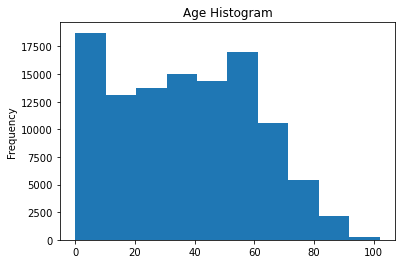

In [26]:
df.age.plot(kind='hist',bins=10)
plt.title('Age Histogram');

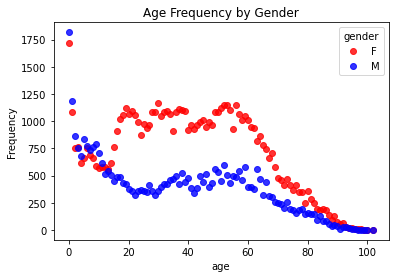

In [27]:
pd.crosstab(df.age, df.gender).plot(style=['or','ob'], alpha=0.8);
plt.title('Age Frequency by Gender')
plt.ylabel('Frequency');

Looking at the Age histogram with a higher number of bins (more granularity), we can see there are basically three age groups with higher frequency than the others: there is a peak for very young patients; another one at around 30-35 years; and the last one around 45-55 years.

The second peak seems to be formed due to a high frequency of females, whereas the third peak has contribution of both male and female, given their proportions in the dataset.

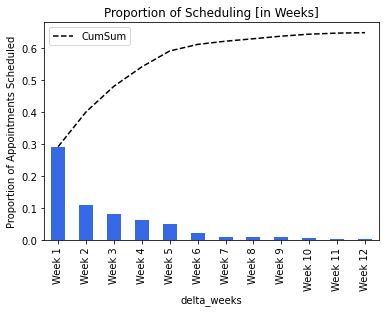

In [28]:
# interval of delta days to be plotted
df['delta_weeks'] = pd.cut(df.delta_date, [pd.Timedelta(i, 'D') for i in range(0,90,7)])
delta_proportion_weeks = df.groupby('delta_weeks').size() / df.shape[0]

delta_proportion_weeks.cumsum().plot(style='k--', label='CumSum')

delta_proportion_weeks.plot(kind='bar', color='xkcd:blue', alpha=0.8, label='_No')
plt.title('Proportion of Scheduling [in Weeks]')
plt.xticks(range(12), ['Week {}'.format(x) for x in range(1,13)])
plt.ylabel('Proportion of Appointments Scheduled')
plt.legend();

# print(delta_proportion_weeks.round(2))

The majority of appointments are scheduled 5 weeks in advance (around 60%), being almost half of these made within 1 week from the actual appointment. Let's further investigate what it looks like for the first 2 weeks:

delta_days
(0 days 00:00:00, 1 days 00:00:00]      0.05
(1 days 00:00:00, 2 days 00:00:00]      0.06
(2 days 00:00:00, 3 days 00:00:00]      0.02
(3 days 00:00:00, 4 days 00:00:00]      0.05
(4 days 00:00:00, 5 days 00:00:00]      0.03
(5 days 00:00:00, 6 days 00:00:00]      0.04
(6 days 00:00:00, 7 days 00:00:00]      0.04
(7 days 00:00:00, 8 days 00:00:00]      0.02
(8 days 00:00:00, 9 days 00:00:00]      0.01
(9 days 00:00:00, 10 days 00:00:00]     0.01
(10 days 00:00:00, 11 days 00:00:00]    0.01
(11 days 00:00:00, 12 days 00:00:00]    0.01
(12 days 00:00:00, 13 days 00:00:00]    0.02
(13 days 00:00:00, 14 days 00:00:00]    0.03
dtype: float64


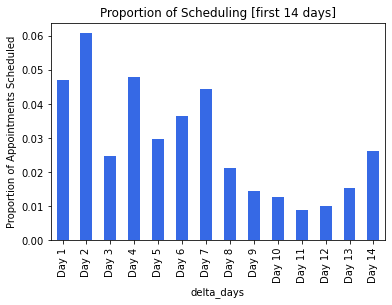

In [29]:
# interval of delta days to be plotted: 14 days
df['delta_days'] = pd.cut(df.delta_date, [pd.Timedelta(i, 'D') for i in range(0,15)])

delta_proportion_days = df.groupby('delta_days').size() / df.shape[0]

delta_proportion_days.plot(kind='bar', color='xkcd:blue', alpha=0.8)
plt.title('Proportion of Scheduling [first 14 days]')
plt.xticks(range(14), ['Day {}'.format(x) for x in range(1,15)])
plt.ylabel('Proportion of Appointments Scheduled')

print(delta_proportion_days.round(2))

There is no clear pattern for the proportion of appointments scheduled within 14 days in advance.
Same day appointments - assumed to be "Emergency" ones - represent only 5% of the sample.

### Research Questions

Since we are interested in investigating the correlation between a specific variable and the final outcome (show vs no-show), it is worth writing a function that will be used multiple times.

The function will cross reference the desired variable against the final outcome (column Attended), normalizing the result between Yes-Attended and No-Attended and plotting a bar chart with the respective title and labels:

In [30]:
def proportion_attendance(feature):
    pd.crosstab(df[feature], df.attended, normalize='columns').plot(kind='bar', alpha=0.85)
    plt.xlabel('Feature: {}'.format(feature.replace('_',' ').title()))
    plt.ylabel('Proportion')
    plt.title('Proportion of Attendance Rate by {}'.format(feature.replace('_',' ').title()))
    plt.margins(y=0.1)
    return plt # this allows for eventual further formatting tweaks

### Q1) Does gender impact the attendance?

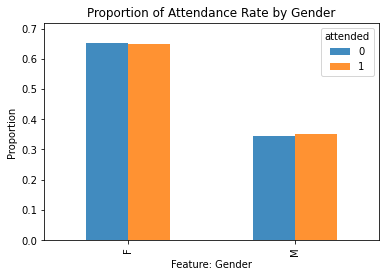

In [31]:
proportion_attendance('gender');

There is no clear evidence that gender have any influence on whether or not the patient is going to show up for their scheduled appointment.

### Q2) Is there a specific age group with higher attendance rate?

Since the age distribution is so spread out, let's transform this numeric variable into age groups - representing $10^{th} $ percentile each - to further investigate this question:

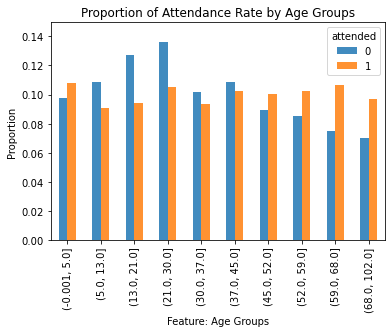

In [32]:
df['age_groups'] = pd.qcut(df.age, 10)
proportion_attendance('age_groups');

It looks like age does have some influence over attendance rate. We can clearly see that patients between 5 and 44 years old seem to be less likely to show up, whereas patients older than 45 seem to be more likely to attend their scheduled appointment. It is also possible to see that patients younger than 5 years old tend to be slightly more likely to attend.

Since the age groups present a distinctively proportion of attendance rate, we can create dummy variables (Hot-One encoded) to capture their influence in the classification model. We will tackle this step later.

### Q3) Does date difference between the scheduled and the appointment day impact the attendance rate? 

Here we are particularly interested in investigating if there is evidence of any pattern that influence attendance rate. For example, one might wonder whether same day appointments have a higher attendance rate, since they could be viewed as surrogate for emergency visits?

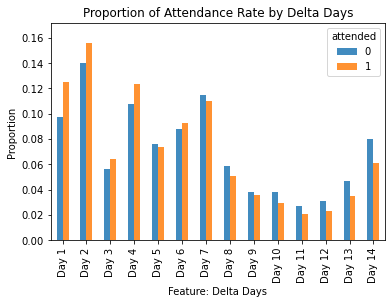

In [33]:
proportion_attendance('delta_days')
plt.xticks(range(14), ['Day {}'.format(i) for i in range(1,15)]);

It looks like the difference between appointment and scheduled dates have some influence over the attendance rate. We can clearly see that appointments scheduled within 4 days in advance seem to be more likely to show up: these could be interpreted as "same week appointments".

In contrast, those scheduled longer than 7 days in advance tend to be less likely to attend.

Since the attendance rate doesn't vary significantly for all delta days, perhaps it would be more meaningful to create 2 dummy variables, representing: appointments scheduled within 4 days in advance, and longer than 7 days in advance.

In [34]:
# Checking for correct filtering
print(df[df.delta_date < pd.Timedelta(5,'D')].delta_date.aggregate([min,max, 'count']))
print(df[df.delta_date > pd.Timedelta(7,'D')].delta_date.aggregate([min,max, 'count']))

min      0 days 00:00:00
max      4 days 17:24:06
count              61801
Name: delta_date, dtype: object
min        7 days 03:36:35
max      178 days 13:19:01
count                39772
Name: delta_date, dtype: object


In [35]:
# Create 2 new features to represent if appointment scheduled <= 4 and > 7 days in advance
df['reg_up_4days'] = np.where( df.delta_date < pd.Timedelta(5,'D') , 1, 0)
df['reg_more_7days'] = np.where( df.delta_date > pd.Timedelta(8,'D') , 1, 0)

### Q4) Are there specific neighborhoods associated with higher No-Show?

In [36]:
df.pivot_table('attended', index='neighborhood', aggfunc=('mean', 'count'))\
    .sort_values(by='mean', ascending=False).head()

,count,mean
neighborhood,,
PARQUE INDUSTRIAL,1,1.000000
ILHA DO BOI,35,0.914286
AEROPORTO,8,0.875000
MÁRIO CYPRESTE,371,0.854447
SOLON BORGES,469,0.852878


At first glance, we can identify some neighborhoods with high attendance rate... but it is important to take into consideration the representativeness of that data. It would be biased to infer the attendance rate of specific neighborhoods based only on the observations of few patients from that specific location (such as Parque Industrial with 100% attendance rate, but only 1 patient).

Therefore, for this particular research questions, let's work only with neighborhoods where the count is equal or greater than the median count of all neighborhoods. Let's call this subset $Neighborhood^*$:

In [37]:
# count of all neighborhoods
neighb_count = df.groupby('neighborhood').size()

# subset, keeping only counts >= the median
neighb_subset = neighb_count[neighb_count >= neighb_count.median()]

# new dataframe, filtered to the previous subset
df2 = df.query('neighborhood in {}'.format(list(neighb_subset.index)))

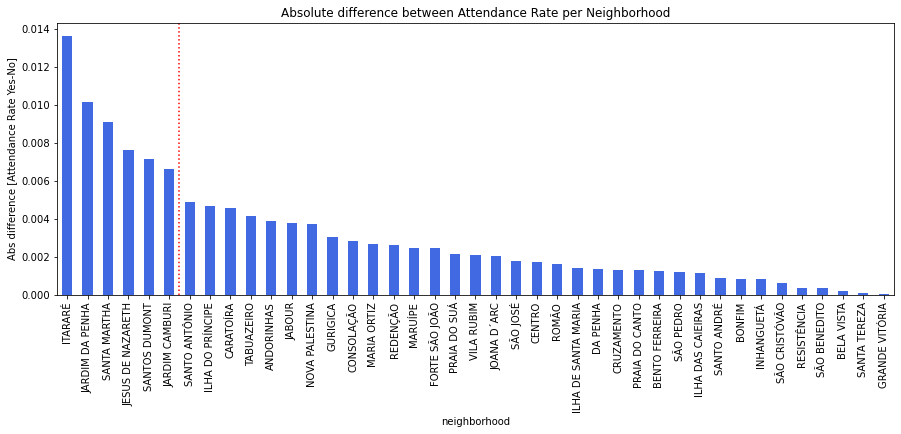

In [38]:
pd.crosstab(df2.neighborhood, df2.attended, normalize='columns')\
.apply(lambda x: abs(x[0] - x[1]), axis=1).sort_values(ascending=False)\
.plot(kind='bar', figsize=(15,5), color='royalblue');
plt.axvline(5.5, color='r', linestyle=':')
plt.ylabel('Abs difference [Attendance Rate Yes-No]')
plt.title('Absolute difference between Attendance Rate per Neighborhood');

We can clearly see there are six neighborhoods with distinctively different proportion of attendance rate. Since the difference is absolute, we don't know yet which locations have positive or negative impact:

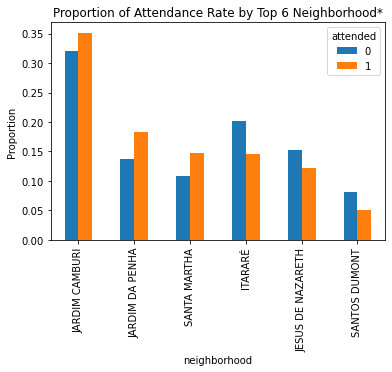

In [39]:
ref = ['ITARARÉ', 'JARDIM DA PENHA', 'SANTA MARTHA', 'JESUS DE NAZARETH', 
       'SANTOS DUMONT', 'JARDIM CAMBURI']
df2 = df2.query('neighborhood in @ref')

pd.crosstab(df2.neighborhood, df2.attended, normalize='columns')\
.sort_values(by=df2.attended[1], ascending=False).plot(kind='bar');
plt.ylabel('Proportion')
plt.title('Proportion of Attendance Rate by Top 6 Neighborhood*');

It looks like patients from Group 1 (Jardim Camburi, Jardim da Penha, Santa Martha) tend to be more likely to show up, whereas those from Group 2 (Itararé, Jesus de Nazareth, Santos Dumont) are less likely.

Perhaps it would be more meaningful for the classification model to create two dummy variables capturing if a patient resides in one of these two groups. We can compare their significance afterwards:
+ **Group 1** (Jardim Camburi, Jardim da Penha, Santa Martha): More likely to show up
+ **Group 2** (Itararé, Jesus de Nazareth, Santos Dumont): Less likely to show up

>Let's create two new features to represent whether a patient is from one of the neighborhoods in Group 1 or Group 2. This will be useful when implementing a regression model.

In [40]:
# Creating 2 new features to capture the impact of these groups
group1 = ['JARDIM CAMBURI', 'JARDIM DA PENHA', 'SANTA MARTHA']
group2 = [ 'ITARARÉ', 'JESUS DE NAZARETH', 'SANTOS DUMONT']

# Excel like function to set value based on condition
df['reg_neighb_group1'] = np.where(np.isin(df.neighborhood, group1), 1, 0)
df['reg_neighb_group2'] = np.where(np.isin(df.neighborhood, group2), 1, 0)

### Q5) Does receiving a scholarship (Bolsa Familia) has any impact on the attendance?

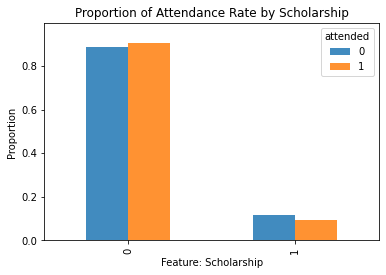

In [41]:
proportion_attendance('scholarship');

Looks like there is a small, but consistent, difference in the proportion of attendance rate based on receiving scholarship "Bolsa Familia". Patients who receive seem less likely to show up, wheres those who do not receive the governmental assistance benefit seem slightly more likely to attend their scheduled appointment.

We can use this variable as a possible explanatory variable in our classification model.

### Q6) Does any medical condition impact the attendance rate?

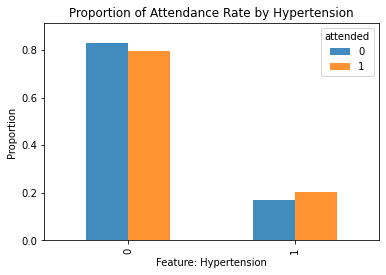

In [42]:
ref_list = ['hypertension', 'diabetes', 'alcoholism', 'handicap']

proportion_attendance('hypertension');

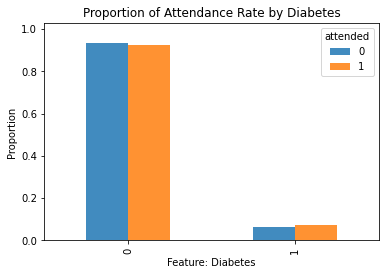

In [43]:
proportion_attendance('diabetes');

Both **Hypertension** and **Diabetes** seem to have an impact on attendance rate, where <u>patients with these medical conditions are more likely to show up</u>. We can later use these variables in the classification model.

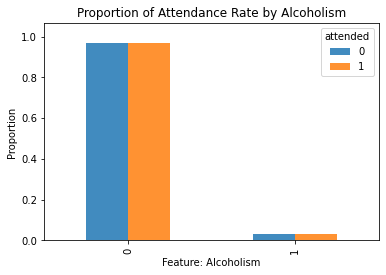

In [44]:
proportion_attendance('alcoholism');

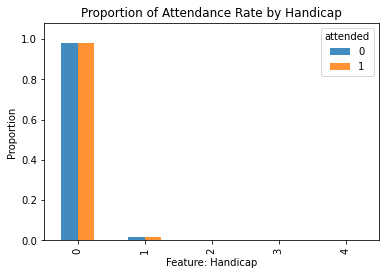

In [45]:
proportion_attendance('handicap');

On the other hand, neither **Alcoholism** nor **Handicap** seem to have <u>any impact over the attendance rate</u>. We should not use these variables to model appointment attendance probability.

### Q7) Does receiving the SMS reminder has any impact on the attendance?

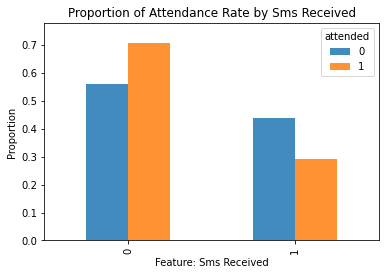

In [46]:
proportion_attendance('sms_received');

Looks like the attendance rate of patients that received the SMS reminder is quite different than those who did not receive. But the interpretation of the observed effect doesn't make sense. It isn't reasonable that a patient would change their mind and decide not to go to their scheduled appointment after receiving the SMS reminder.

In this case, even though there is evidence this variable impact the attendance rate, <u>we should ignore it due to lack of explainability</u>.

### Q8) Is it possible to, based on the available features, predict whether a patient will show up to their scheduled appointment?

Since our response is a binary variable containing data coded as 1 (yes/success) and 0 (no/failure), we can implement the classification algorithm: Logistic Regression. The model predicts the probability (between 0 and 100%) of the dependent variable as a function of the features.

> The following procedures were based on the very well written Medium Post from Susan Li, entitled [Building a Logistic Regression in Python, step-by-step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8).

In [47]:
# Checking proportion of Attended: Yes/1 vs No/0
prop_attended = df.attended.mean()
prop_no_show = 1 - prop_attended
ratio = prop_attended / prop_no_show

print('Percentage of Attended: {:.2f} | Percentage of No-Show: {:.2f}'\
      .format(prop_attended, prop_no_show))
print('Ratio: {:.0f}:1'.format(ratio))

Percentage of Attended: 0.80 | Percentage of No-Show: 0.20
Ratio: 4:1


The classes are imbalanced with a ratio of 4:1 of Attended vs No-Show. 

In order to avoid overfit our model estimation, we need to balance the classes by Over-Sampling the training data (otherwise it would be biased toward predicting Yes/Attended, since it would be right 4 out of 5 times). 

Let's use the [SMOTE algorithm](https://arxiv.org/pdf/1106.1813.pdf) (Synthetic Minority Oversampling Technique).

>As described on the post by Susan Li, this algorithm can be understood, at a high level, as it:
+ Works by creating synthetic samples from the minor class (in this case, No-Attended) instead of creating copies.
+ Randomly chooses one of the *k-nearest-neighbors* and uses it to create a similar, but randomly tweaked, new observations.

To quote Susan's observation:
> *"... by <mark>oversampling only on the training data</mark>, none of the information in the test data is being used to create synthetic observations, therefore, no information will 'bleed' from the test data into the model training."*

First, let's create the dummy variables for the features showing potential of being good predictors for out model. We will do so by using a native Pandas function:

In [48]:
# Creating Dummy Variables for categories in Age_Groups
dummy = pd.get_dummies(df['age_groups'], prefix='age_gr')
df = df.join(dummy)

In [49]:
# Checking if dummy variables were created correctly
df.columns

Index(['gender', 'scheduled_day', 'appointment_day', 'age', 'neighborhood',
       'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap',
       'sms_received', 'attended', 'delta_date', 'delta_weeks', 'delta_days',
       'age_groups', 'reg_up_4days', 'reg_more_7days', 'reg_neighb_group1',
       'reg_neighb_group2', 'age_gr_(-0.001, 5.0]', 'age_gr_(5.0, 13.0]',
       'age_gr_(13.0, 21.0]', 'age_gr_(21.0, 30.0]', 'age_gr_(30.0, 37.0]',
       'age_gr_(37.0, 45.0]', 'age_gr_(45.0, 52.0]', 'age_gr_(52.0, 59.0]',
       'age_gr_(59.0, 68.0]', 'age_gr_(68.0, 102.0]'],
      dtype='object')

In [50]:
# Keeping only NUMERICAL and potential predictors for model regression
to_keep = ['scholarship', 'hypertension', 'diabetes', 'reg_up_4days', 'reg_more_7days',
           'reg_neighb_group1','reg_neighb_group2', 'age_gr_(-0.001, 5.0]', 'age_gr_(5.0, 13.0]',
           'age_gr_(13.0, 21.0]', 'age_gr_(21.0, 30.0]', 'age_gr_(30.0, 37.0]',
           'age_gr_(37.0, 45.0]','age_gr_(45.0, 52.0]', 'age_gr_(52.0, 59.0]',
           'age_gr_(59.0, 68.0]', 'age_gr_(68.0, 102.0]']

df_model = df[to_keep]

In [51]:
# Balancing response classes with Over-sampling (SMOTE algorithm)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_model # features
y = df['attended'] # response

# randomly splitting a proportion of dataset into train/test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

# generating synthetic samples only for training dataset
os = SMOTE(random_state=0)
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

# storing them back as dataframes
X_train = pd.DataFrame(data=os_data_X, columns=columns)
y_train = pd.DataFrame(data=os_data_y, columns=['attended'])

In [52]:
# Checking the classes in oversampled data
prop_attended = y_train.attended.mean()
prop_no_show = 1 - prop_attended
ratio = prop_attended / prop_no_show

print("Length of oversampled data:",len(X_train))
print("Number of Attended:", len(y_train.query('attended == 1')))
print("Number of No-Show:", len(y_train.query('attended == 0')))
print('Percentage of Attended: {:.2f} | Percentage of No-Show: {:.2f}'\
      .format(prop_attended, prop_no_show) )
print('Ratio of Response in oversampled data: {:.0f}:1'.format(ratio))

Length of oversampled data: 123356
Number of Attended: 61678
Number of No-Show: 61678
Percentage of Attended: 0.50 | Percentage of No-Show: 0.50
Ratio of Response in oversampled data: 1:1


In [53]:
print('Synthetic Training Sample | Total rows: {} | # Yes-Attended: {} | # No-Attended: {}'.\
      format(len(X_train), y_train.attended.sum(), len(y_train) - y_train.attended.sum()))

print('     Original Sample      | Total rows: {} | # Yes-Attended: {} | # No-Attended: {}'.\
      format(len(X), y.sum(), len(y) - y.sum()))

Synthetic Training Sample | Total rows: 123356 | # Yes-Attended: 61678 | # No-Attended: 61678
     Original Sample      | Total rows: 110516 | # Yes-Attended: 88205 | # No-Attended: 22311


Now that our training data (shuffled 70% of dataset) has a balanced proportion of the outcome (Attend), we can use it to train our classification model without overfitting it.

We can apply a feature selection method to identify the most significant features from our extensive list of possible candidates. 

But the method described in the post ([**Recursive Feature Elimination**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)) has a limitation: it requires the scientist to arbitrarily set the final number of predictors! Which kind of defeats the purpose of finding the most significant ones.

Instead, we are going to implement a variation of such method, the [**Recursive Feature Elimination with Cross Validation**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV): it recursively build models, identifying the best and worst performing features, setting then aside and continuing the process with the remaining features until they all have been evaluated. It ranks the best performing features, while using Cross-Validation to select the best number of predictors.

Let's apply the **RFECV** method using a Logit function as the estimator, removing only 1 feature at a time, and using 5-fold cross-validation:

In [54]:
# transform y_train into array of shape (n,) - as required to fit the model
y_train = y_train.attended

In [55]:
# Applying RFE with Cross Validation
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear')

rfeCV = RFECV(logit, step=1,cv=5, n_jobs=-1)
rfeCV = rfeCV.fit(X_train, y_train)
# print(rfeCV.support_)

In [56]:
top_predictors = [k for k,v in zip(X_train.columns, rfeCV.support_) if v == True]
[print(i) for i in top_predictors]; # 12 or 7 predictors

scholarship
diabetes
reg_up_4days
reg_more_7days
reg_neighb_group1
reg_neighb_group2
age_gr_(5.0, 13.0]
age_gr_(13.0, 21.0]
age_gr_(21.0, 30.0]
age_gr_(30.0, 37.0]
age_gr_(37.0, 45.0]
age_gr_(59.0, 68.0]
age_gr_(68.0, 102.0]


Let's filter the training sample to include only the top performing features identified by the RFECV method:

In [57]:
X_train = X_train[top_predictors]

Let's fit a Logistic Regression model in order to evaluate the significance of the identified features. We will do so using <code>statsmodels</code> since it has a more detailed result summary:

In [58]:
# Logistic Regression - Evaluating Features using statsmodels (better result summary)
import statsmodels.api as sm

logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.642914
         Iterations 5
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.072      
Dependent Variable:  attended          AIC:               158640.6321
Date:                2022-09-06 13:40  BIC:               158767.0288
No. Observations:    123356            Log-Likelihood:    -79307.    
Df Model:            12                LL-Null:           -85504.    
Df Residuals:        123343            LLR p-value:       0.0000     
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      5.0000                                          
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
scholarship          -0.1754   0.0198  -8.8422 0.0000 -0.2143 -0.1365
diabetes        

All variables presented p-value smaller than the significance level of 5%. This means the **RFECV** did a good job selecting the best performing features.



After the third round, the model looks good. All features have p-value less than significance level of 5%, meaning they are significant.

Also, the coefficients have the correct expected signal, as mentioned through the analysis.

### Odd's Ratio
We can interpret the Odd's ratio by calculating $exp(coef.)$:
>**Obs**: it is necessary to correct the Odd's Ratio for values where $exp(coef.) < 1$. By inverting, we transform it into the regular proportion/ratio form, but it is necessary to add a negative sign, since it has an inverted effect.

In [59]:
coefficients = list(result.params.values)
odds_ratio = np.exp(coefficients)

# Correcting Odds Ratio for values <1
odds_ratio = [i if i >= 1 else -1/i for i in odds_ratio]

df_odds_ratio = pd.DataFrame({'Coefficient':top_predictors , 'Odds Ratio': odds_ratio})
df_odds_ratio['Odds Ratio'] = df_odds_ratio['Odds Ratio'].round(1)

import scipy.stats as ss
df_odds_ratio['Ranking'] = ss.rankdata([-1 * abs(i) for i in df_odds_ratio['Odds Ratio']],
                                       method='dense')
df_odds_ratio.sort_values(by='Ranking')

,Coefficient,Odds Ratio,Ranking
2,reg_up_4days,2.3,1
7,"age_gr_(13.0, 21.0]",-1.6,2
3,reg_more_7days,-1.5,3
8,"age_gr_(21.0, 30.0]",-1.5,3
6,"age_gr_(5.0, 13.0]",-1.4,4
5,reg_neighb_group2,-1.3,5
10,"age_gr_(37.0, 45.0]",-1.3,5
0,scholarship,-1.2,6
1,diabetes,-1.2,6
9,"age_gr_(30.0, 37.0]",-1.2,6


Here is the Odd's Ratio interpretation, ordered by the features with the most impact over the attendance likelihood:

1. Appointments scheduled less than 4 days in advance are 2.3 times more likely to attend;
2. Patients between the ages of 13 and 21 years old were 1.6 times <u>less likely</u> to show up;
3. Tied in third place being 1.5 times less likely to show up:
    - <mark>Appointments scheduled more than 7 days in advance</mark>
    - <mark>Patients between the ages of 21 and 30 years</mark>
4. Patients wwithin the ages of 5 to 13 years were 1.4 times <u>less likely</u> to show up;
   - Patients residing in one of the neighborhoods in **Group 2** *(Jesus de Nazareth, Itarare, Santos Dumont)*

5. Tied in fifth place being 1.3 times more likely to show up:
    - <mark> - Patients residing in one of the neighborhoods in **Group 2** *(Jesus de Nazareth, Itarare, Santos Dumont)*</mark>
    - <mark>Patients between age 37 and 45 years </mark>
    
6. Tied in sixth place, being 1.2 times <u>less likely</u> to show up:
    - Patients participating in the governmental assistance program (scholarship: *Bolsa Familia*)
    - Patients with diabetes
    - Patients between the ages of 30 to 37 years
7. Tied in seventh place, being 1.1 times more likely to show up to their scheduled appointment:
    - Patients residing in one of the neighborhoods in **Group 1** *(Santa Martha, Jardim da Penha, Vila Rubim)* are 1.1 times more likely  to attend.
    - <mark>Patients between 59 and 68 years old</mark>
    - <mark>Patients between 68 and 102 years old</mark>


### Model Performance
Ok, now we are ready to evaluate the performance of our Logit Model:

In [60]:
# Logistic Regression - Model Performance
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logit = LogisticRegression(solver='liblinear')
logit.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Making sure our test sample contains only the significant features previously identified and used in the training sample:

In [61]:
features = list(X_train.columns.values)
X_test = X_test[features]
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'\
      .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.63


Now let's evaluate **precision** and **recall** based on the *Confusion Matrix*:

In [62]:
from sklearn.metrics import confusion_matrix

y_pred = logit.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 4411  2217]
 [10093 16434]]


| Response | Predicted NO | Predicted YES |
| --- | --- | --- |
| Actual NO | 4,411 | 2,217 |
| Actual YES | 10,093 | 16,434 |

The result is telling us that we have **4,411 + 16,434 = 20,845** correct predictions (True Positives + True Negatives) and **2,217 + 10,093 = 12,310** incorrect predictions (False Positives + False Negatives)


As described in Scikit Learn:

The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. It can be understood as the proportion of correct predictions over all predictions made for each outcome (Yes/No).

The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. It can be understood as the proportion of correct predictions over the total number of occurrences of each known outcome (Yes/No).

recall is intuitively the ability of the classifier to find all the positive samples.

The **F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The **support** is the number of occurrences of each class in y_test.

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.67      0.42      6628
           1       0.88      0.62      0.73     26527

    accuracy                           0.63     33155
   macro avg       0.59      0.64      0.57     33155
weighted avg       0.77      0.63      0.67     33155



We can interpret that our model is quite pessimistic, making several predictions that a patient would NOT show up for their appointment, but only getting it right 30% of the time. By contrast, the model doesn't make as much positive predictions as it should - since the vast majority of outcomes in the testing sample is positive. This suggests the synthetic generated observations in our training sample (in order to balance the classes) actually protected the model from overfitting.

Overall, the Logistic model predicts the right outcome 63% of the time ($\frac{TP + TN}{Total}$).

<a id='conclusions'></a>
## Conclusions

After thoroughly investigating all the research questions, we were able to identify that some features seems to actually impact the likelihood of a patient attending the appointment scheduled. To be more specific, some particular groups of those features showed an attendance rate different than the other groups and/or the overall average.
> Although, it is important to highlight that, without the proper statistical testing, we cannot ascertain with statistical significance there is indeed a correlation between the features and the attendance rate. 

>This descriptive statistical analysis allow us to identify features with possible correlation to the dependent variable - which would be interesting to further investigate using hypothesis testing and/or regression models.

Here is a summary of the initial findings:
+ Gender does not seem to have any impact with the attendance rate;
+ Age groups:
    - **Less than 5 years and over 45 years old**: seems to be more likely to show up
    - **Between 5 and 45 years old**: seems to be less likely to show up
+ Date difference between appointment and when it was scheduled:
    - **Appointments scheduled up to 4 days in advance**: seems to be more likely to show up
    - **Appointments scheduled more than 7 days in advance**: less likely to attend
+ Neighborhood groups:
    - **Group 1** (Jardim Camburi,  Jardim da Penha, Santa Martha): seems to be more likely to show up
    - **Group 2** (Itararé, Jesus de Nazareth, Santos Dumont): seems to be less likely to show up
+ Patients receiving Scholarship (Bolsa Familia) are less likely to show up;
+ Medical Conditions: patients suffering from alcoholism and diabetes seems to be slightly more likely to attend
+ SMS reminder: even though there is evidence receiving an SMS reminder seems to make the patients less likely to show up, we should ignore this variable due to lack of explainability.

<hr>
After fitting a Logistic Regression model, we ended up with 12 best performing and statistically significant explanatory variables. Their coefficients have the correct expected signal, based on the initial analysis.

According to the Odd's ratio analysis, we are able to rank the features based on their impact on the attendance rate:

1. Appointments scheduled less than 4 days in advance are 2.3 times more likely to attend;
2. Patients between the ages of 13 and 21 years old were 1.6 times <u>less likely</u> to show up;
3. Tied in third place being 1.5 times less likely to show up:
    - <mark>Appointments scheduled more than 7 days in advance</mark>
    - <mark>Patients between the ages of 21 and 30 years</mark>
4. Patients wwithin the ages of 5 to 13 years were 1.4 times <u>less likely</u> to show up;
   - Patients residing in one of the neighborhoods in **Group 2** *(Jesus de Nazareth, Itarare, Santos Dumont)*

5. Tied in fifth place being 1.3 times more likely to show up:
    - <mark> - Patients residing in one of the neighborhoods in **Group 2** *(Jesus de Nazareth, Itarare, Santos Dumont)*</mark>
    - <mark>Patients between age 37 and 45 years </mark>
    
6. Tied in sixth place, being 1.2 times <u>less likely</u> to show up:
    - Patients participating in the governmental assistance program (scholarship: *Bolsa Familia*)
    - Patients with diabetes
    - Patients between the ages of 30 to 37 years
7. Tied in seventh place, being 1.1 times more likely to show up to their scheduled appointment:
    - Patients residing in one of the neighborhoods in **Group 1** *(Santa Martha, Jardim da Penha, Vila Rubim)* are 1.1 times more likely  to attend.
    - <mark>Patients between 59 and 68 years old</mark>
    - <mark>Patients between 68 and 102 years old</mark>

It is possible to see the highlighted variables actually have a similar impact. These age groups could be merged together and the dummy variable would still be able to capture its influence.

The final Logistic model is quite pessimistic, making several predictions that a patient would NOT show up for their appointment, but only getting it right 30% of the time. By contrast, the model doesn't make as much positive predictions as it should - since the vast majority of outcomes in the testing sample is positive. 

Interestingly, this suggests the synthetic generated observations in our training sample (in order to balance the classes) did indeed protect the model from overfitting. This seem to be a good approach for handling datasets with unbalanced classes.

Overall, the Logistic model predicts the right outcome 63% of the time ($\frac{TP + TN}{Total}$). Which is better than flipping a coin, but still has room for improvement before it can be considered useful.

### Recommendation for Future Research
The advantage of using a Logistic Regression model is it's explanatory power: it allows for interesting inference capabilities such as Odd's Ratio and Elasticity analysis. Although it lacks prediction accuracy power.

For this particular case study, the inference power of the Logit model is rendered useless, since the doctors cannot control the characteristics of their patients. Their main goal is to accurately predict whether or not a patient is going to show up for their scheduled appointment.

Therefore, it would be interesting to fit the data using more advanced methods, such as Naive Bayes, Support Vector Machine (SVM), Boosting, Random Forest, and even Artificial Neural Network. 